# Homework 3

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse

# 1. Uncertainty ellipses for HW1

In [11]:
df = pd.read_pickle('hw1_data.pkl')
df.head()

,ID,x,y,sigma_y,sigma_x,rho_xy
0,1,201,592,61,9,-0.84
1,2,244,401,25,4,0.31
2,3,47,583,38,11,0.64
3,4,287,402,15,7,-0.27
4,5,203,495,21,5,-0.33


Best-fit b: 34.048
Best-fit m: 2.240


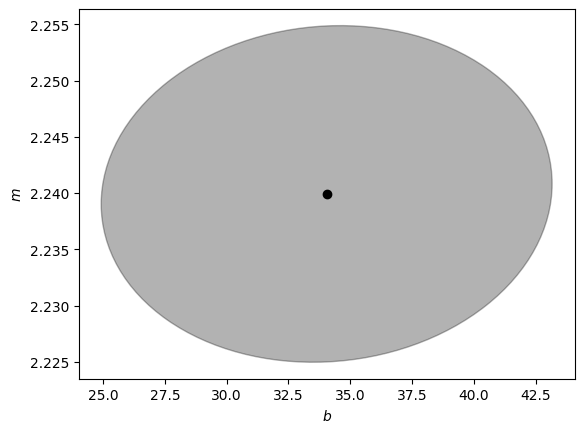

In [46]:
df1 = df.loc[df.ID > 4]

def lin_regress(x, y, sigma_y):
    def into_array(v):
        if not isinstance(v, np.ndarray):
            return np.array(v)
        
    (x, y, sigma_y) = map(into_array, (x, y, sigma_y))
    N = len(x)
    
    A = np.ones((N, 2))
    A[:, 1] = x  # ones in first col, x values in second col
    Y = y.reshape((N, 1))
    C_inv = (1. / (sigma_y ** 2)).reshape((N, 1))
    
    theta = np.linalg.solve(A.T @ (C_inv * A), A.T @ (C_inv * Y))
    cov = np.linalg.inv(A.T @ (C_inv * A))
    return theta, cov

theta, cov = lin_regress(df1.x, df1.y, df1.sigma_y)

b1, m1 = theta[0].item(), theta[1].item()
print(f"Best-fit b: {b1:.3f}")
print(f"Best-fit m: {m1:.3f}")

# find eigenvalues of covariance matrix
eigval, eigvec = np.linalg.eig(cov)
std_err1 = np.sqrt(eigval)
angle1 = np.arccos(np.dot(eigvec[:, 0], np.array([1, 0])))

fig, ax = plt.subplots()
el = Ellipse((b1, m1), width=std_err1[0], height=std_err1[1], angle=angle1,
             color='black', alpha=0.3)
ax.add_patch(el)
ax.plot(b1, m1, 'ko', zorder=1)
ax.set_xlabel("$b$")
ax.set_ylabel("$m$")
plt.show()

Best-fit b: 213.273
Best-fit m: 1.077


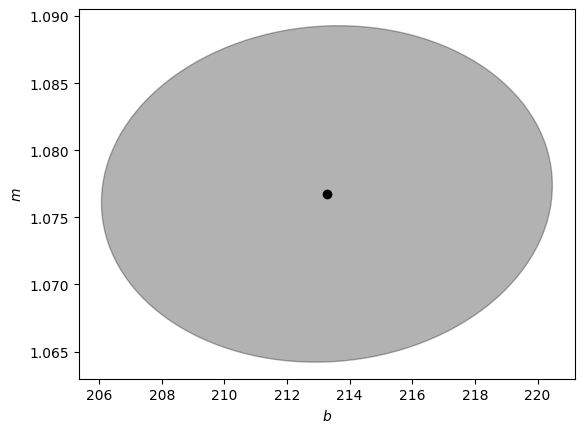

In [48]:
df2 = df.copy()

def lin_regress(x, y, sigma_y):
    def into_array(v):
        if not isinstance(v, np.ndarray):
            return np.array(v)
        
    (x, y, sigma_y) = map(into_array, (x, y, sigma_y))
    N = len(x)
    
    A = np.ones((N, 2))
    A[:, 1] = x  # ones in first col, x values in second col
    Y = y.reshape((N, 1))
    C_inv = (1. / (sigma_y ** 2)).reshape((N, 1))
    
    theta = np.linalg.solve(A.T @ (C_inv * A), A.T @ (C_inv * Y))
    cov = np.linalg.inv(A.T @ (C_inv * A))
    return theta, cov

theta, cov = lin_regress(df2.x, df2.y, df2.sigma_y)

b2, m2 = theta[0].item(), theta[1].item()
print(f"Best-fit b: {b2:.3f}")
print(f"Best-fit m: {m2:.3f}")

# find eigenvalues of covariance matrix
eigval, eigvec = np.linalg.eig(cov)
std_err2 = np.sqrt(eigval)
angle2 = np.arccos(np.dot(eigvec[:, 0], np.array([1, 0])))

fig, ax = plt.subplots()
el = Ellipse((b2, m2), width=std_err2[0], height=std_err2[1], angle=angle2,
             color='black', alpha=0.3)
ax.add_patch(el)
ax.plot(b, m, 'ko', zorder=1)
ax.set_xlabel("$b$")
ax.set_ylabel("$m$")
plt.show()

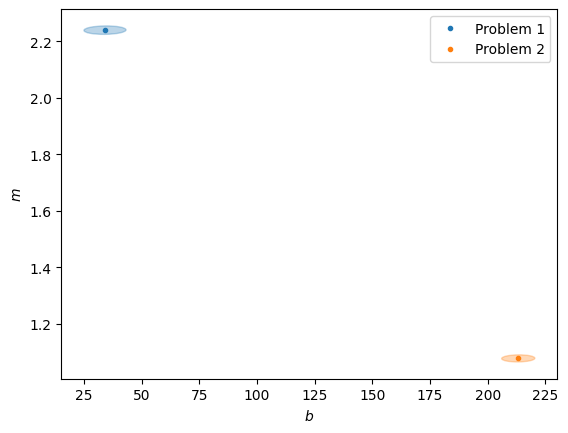

In [53]:
# On the same plot for comparison
fig, ax = plt.subplots()

el = Ellipse((b1, m1), width=std_err1[0], height=std_err1[1], angle=angle1,
             color='C0', alpha=0.3)
ax.add_patch(el)
ax.plot(b1, m1, '.', color='C0', zorder=1, label='Problem 1')

el = Ellipse((b2, m2), width=std_err2[0], height=std_err2[1], angle=angle2,
             color='C1', alpha=0.3)
ax.add_patch(el)
ax.plot(b, m, '.', color='C1', zorder=1, label='Problem 2')
ax.legend()
ax.set_xlabel("$b$")
ax.set_ylabel("$m$")
plt.show()

# 2. Standard error for HW2

In [65]:
import pickle
import hw2_utils as u
from tqdm.auto import tqdm

# Load the data
with open("hw2_data.pkl", "rb") as f:
    data = pickle.load(f).T

t_i = data[0]
sigma_i = data[1]
y_i = data[-1]

data = (t_i, sigma_i, y_i)

Testing frequencies:   0%|          | 0/1485 [00:00<?, ?value/s]

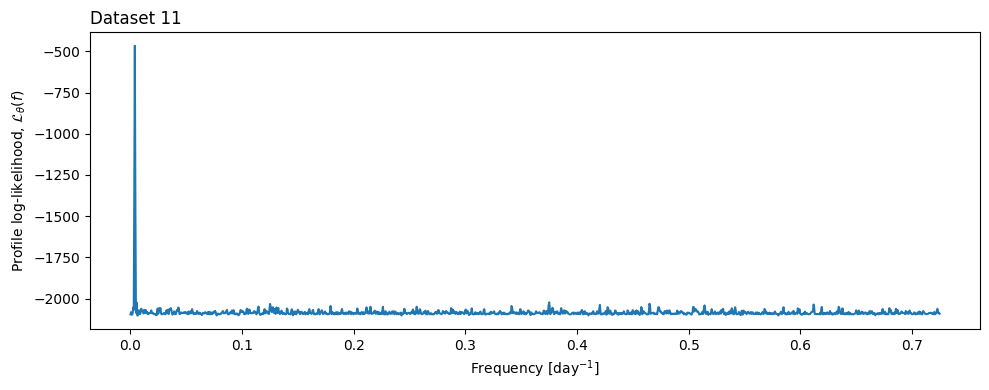

In [66]:
# Compute profile log-likelihood
# Profile out all parameters except frequency
# Result: log-likelihood function that depends only on f

def compute_freq_grid():
    freqs = 1 / np.diff(t_i)
    max_f = 0.5 * np.median(freqs)  # approx Nyquist
    f_width = 1 / 2048
    freq_grid = np.arange(0, max_f + f_width/2, step=f_width)
    return freq_grid

freq_grid = compute_freq_grid()
freq_search_logls = np.zeros_like(freq_grid)

data = (t_i, y_i, sigma_i)
for j, freq in enumerate(tqdm(freq_grid, desc="Testing frequencies", unit="value")):
    _, logl = u.max_likelihood_estimate_profile(u.two_signal_model, [0, 1, 1, 1, 1], [freq], data)
    freq_search_logls[j] = logl
    
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freq_grid, freq_search_logls)
ax.set_title("Dataset 11", loc="left")
ax.set_xlabel("Frequency [day$^{-1}$]")
ax.set_ylabel("Profile log-likelihood, $\\mathcal{L}_{\\theta}(f)$")
fig.tight_layout()
plt.show()

In [71]:
def fit_parabola(x, y):
    """interpolate parabola through three points"""
    X = np.array([[_x**2, _x, 1] for _x in x])
    y = np.reshape(y, (-1, 1))
    theta = np.linalg.solve(X, y)
    a, b, c = theta[:, 0]
    return a, b, c

# find best frequency
index = np.argmax(freq_search_logls)
s = slice(index - 1, index + 2)
a, b, c = fit_parabola(freq_grid[s], freq_search_logls[s])
f_vertex = -0.5 * b / a
print(f"The best fit frequency is {f_vertex:.3e} days^-1, e.g. a period of {1/f_vertex:.1f} days.")

# standard error
fisher_info = - 2 * a  # = - d^2 parabola / df^2
var_lower_bound = 1 / fisher_info
std_err = np.sqrt(var_lower_bound)
print(f"The standard error estimated by the Cramér-Rao bound is {std_err:.3e} days^-1.")

The best fit frequency is 3.895e-03 days^-1, e.g. a period of 256.7 days.
The standard error estimated by the Cramér-Rao bound is 1.124e-05.


Using error propagation, we can compute the standard error on the period. $T = f^{-1}$, so
$$
\sigma_T^2
\approx \left| \frac{dT}{df} \right|^2_{f=f_{\text{best}}} \sigma_f^2
= f^{-2}_{\text{best}} \sigma_f^2
$$

In [74]:
var_T = 1/f_vertex**2 * var_lower_bound
std_err_T = np.sqrt(var_T)
print(f"The Cramér-Rao bound on the period is a standard error of {std_err_T:.3e} days.")

The Cramér-Rao bound on the period is a standard error of 2.886e-03 days.


# 3. Problems 2, 4, 10 from 1710.06068